In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

## Optimizing q for Exponential Holder Bound

In [214]:
def A(t, n):
    '''
    Numerically stable implementation of n * log(1 + e^t).
    '''
    return n * np.sum(np.maximum(t, 0) + np.log(1 + np.exp(-np.abs(t))))
    
def dA(t, n):
    return n * jax.nn.sigmoid(t)
    
def A_cp(t, n):
    return n * cp.sum(cp.logistic(t))

def opt_q_cp(n, theta_0, v, a):
    '''
    CVXPY implementation of finding optimal q
    '''    
    A0 = A(theta_0, n)
    q = cp.Variable(pos=True)
    objective_fn = (
        (A_cp(theta_0 + (q+1) * v, n) - A0)
        + a
    ) / (q + 1)
    objective = cp.Minimize(objective_fn)
    problem = cp.Problem(objective)
    problem.solve(qcp=True)
    return q.value + 1 

In [247]:
def phi_t(q, t, n, theta_0, v):
    '''
    Computes phi_t(q) defined as
        A(theta_0 + qv) - tq 
    '''
    return A(theta_0 + q * v, n) - t * q
    
def dphi_t(q, t, n, theta_0, v):
    '''
    Computes dphi_t(q)/dq given by
        A'(theta_0 + qv)^T v - t
    '''
    return jnp.sum(dA(theta_0 + q*v, n) * v) - t

def transform(u):
    return 1 + A(u, 1)
    
def dtransform(u):
    return dA(u, 1)
    
def inv_transform(q):
    return (q-1) + jnp.log(1 - jnp.exp(1-q))
    
def convex_feasible(
    t, n, theta_0, v, bound, 
    q0=2, tol=1e-7, max_tol=1e7, gamma_tol=1e7, max_iters=int(1e3),
):
    '''
    We say phi_t(q) is feasible if there exists q >= 1
    such that phi_t(q) <= bound, where bound == A(theta_0) - a.
    To unconstrain the minimization problem, we parametrize q = log(1 + e^u) + 1.
    We are using the Barzilai-Borwein method,
    so we must guarantee that the newly parametrized function is also convex and Lipschitz.

    Returns True if phi_t(q) is feasible.
    '''
    u0 = inv_transform(q0)

    u_prev = u0 - jnp.maximum(1, tol)
    q_prev = transform(u_prev)
    dphi_t_u_prev = dphi_t(q_prev, t, n, theta_0, v) * dtransform(u_prev)

    u = u0
    q = q0
    phi_t_u = phi_t(q, t, n, theta_0, v)
    dphi_t_u = dphi_t(q, t, n, theta_0, v) * dtransform(u)

    iter = 0
    while (phi_t_u > bound) and (jnp.abs(u - u_prev) > tol) and (iter < max_iters) and jnp.abs(u) <= max_tol:
        # compute descent quantities
        abs_delta_dphi_t_u = jnp.abs(dphi_t_u - dphi_t_u_prev)
        abs_delta_u = jnp.abs(u - u_prev)
        if abs_delta_u > gamma_tol * abs_delta_dphi_t_u:
            break
        gamma = abs_delta_u / abs_delta_dphi_t_u

        # update previous states
        u_prev = u
        q_prev = q
        dphi_t_u_prev = dphi_t_u
        
        # update current states
        u = u - gamma * dphi_t_u
        q = transform(u)
        phi_t_u = phi_t(q, t, n, theta_0, v)
        dphi_t_u = dphi_t(q, t, n, theta_0, v) * dtransform(u)

        iter += 1
        
    return q, phi_t_u, (phi_t_u <= bound), iter
    
def qcp_solve(n, theta_0, v, a, q0=2, bs_tol=1e-3, **kwargs):
    A0 = A(theta_0, n)
    bound = A0 - a

    # theoretical bounds that contain the minimum value
    lower = A(theta_0 + v, n) - A0
    upper = n * jnp.sum(jnp.maximum(v, 0))
    
    q = jnp.inf
    hint = q0

    while upper - lower >= bs_tol:
        mid = (upper + lower) / 2
        q_new, _, is_feasible, _ = convex_feasible(mid, n, theta_0, v, bound, q0=hint, **kwargs)    
        if is_feasible:
            upper = mid
            q, hint = q_new, q_new
        else:
            lower = mid
    
    return q

In [335]:
# JAX version of the above
class QCPSolver():
    '''
    
    '''

    def __init__(
        self, 
        n,
        a,
        cp_convg_tol=1e-6, 
        cp_max_entropy_tol=1e7, 
        cp_gamma_tol=1e7, 
        cp_max_iters=int(1e2),
        qcp_q0 = 2.,
        qcp_convg_tol=1e-3,
    ):
        self.n = n
        self.a = a
        self.cp_convg_tol = cp_convg_tol
        self.cp_max_entropy_tol = cp_max_entropy_tol
        self.cp_gamma_tol = cp_gamma_tol
        self.cp_max_iters = cp_max_iters
        self.qcp_q0 = qcp_q0
        self.qcp_convg_tol = qcp_convg_tol
        
    def logistic(self, t):
        '''
        Numerically stable implementation of log(1 + e^t).
        '''
        return jnp.maximum(t, 0) + jnp.log(1 + jnp.exp(-jnp.abs(t)))

    def A(self, t):
        return self.n * jnp.sum(self.logistic(t))
        
    def dA(self, t):
        return self.n * jax.nn.sigmoid(t)

    def phi_t(self, q, t, theta_0, v):
        '''
        Computes phi_t(q) defined as
            A(theta_0 + qv) - tq 
        '''
        return self.A(theta_0 + q * v) - t * q
        
    def dphi_t(self, q, t, theta_0, v):
        '''
        Computes dphi_t(q)/dq given by
            A'(theta_0 + qv)^T v - t
        '''
        return jnp.sum(self.dA(theta_0 + q * v) * v) - t

    def transform(self, u):
        return 1 + self.logistic(u)
        
    def dtransform(self, u):
        return jax.nn.sigmoid(u)
        
    def inv_transform(self, q):
        return (q-1) + jnp.log(1 - jnp.exp(1-q))

    def convex_feasible(
        self, t, theta_0, v, bound, q_hint,
    ):
        '''
        We say phi_t(q) is feasible if there exists q >= 1
        such that phi_t(q) <= bound, where bound == A(theta_0) - a.
        To unconstrain the minimization problem, we parametrize q = log(1 + e^u) + 1.
        We are using the Barzilai-Borwein method,
        so we must guarantee that the newly parametrized function is also convex and Lipschitz.

        Returns True if phi_t(q) is feasible.
        '''
        q0 = q_hint
        u0 = self.inv_transform(q0)

        u_prev = u0 - jnp.maximum(1, 2*self.cp_convg_tol)
        q_prev = self.transform(u_prev)
        dphi_t_u_prev = self.dphi_t(q_prev, t, theta_0, v) * self.dtransform(u_prev)

        u = u0
        q = q0
        phi_t_u = self.phi_t(q, t, theta_0, v)
        dphi_t_u = self.dphi_t(q, t, theta_0, v) * self.dtransform(u)

        iter = 0
        
        def _cond_func(args):
            (
                u_prev,
                _,
                _,
                u,
                _,
                phi_t_u,
                _, 
                iter,
            ) = args
            return (
                (phi_t_u > bound) & 
                (jnp.abs(u - u_prev) > self.cp_convg_tol) & 
                (iter < self.cp_max_iters) & 
                (jnp.abs(u) <= self.cp_max_entropy_tol)
            )

        def _body_func(args):
            (
                u_prev,
                q_prev,
                dphi_t_u_prev,
                u,
                q,
                phi_t_u,
                dphi_t_u, 
                iter,
            ) = args

            # compute descent quantities
            abs_delta_dphi_t_u = jnp.abs(dphi_t_u - dphi_t_u_prev)
            abs_delta_u = jnp.abs(u - u_prev)
            early_exit = (abs_delta_u > self.cp_gamma_tol * abs_delta_dphi_t_u)
            gamma = jnp.where(early_exit, 0, abs_delta_u / abs_delta_dphi_t_u)

            # update previous states
            u_prev = u
            q_prev = q
            dphi_t_u_prev = dphi_t_u
            
            # update current states
            u = u - gamma * dphi_t_u
            q = self.transform(u)
            phi_t_u = self.phi_t(q, t, theta_0, v)
            dphi_t_u = self.dphi_t(q, t, theta_0, v) * self.dtransform(u)

            iter = iter + 1
            
            return (
                u_prev, q_prev, dphi_t_u_prev,
                u, q, phi_t_u, dphi_t_u, iter
            )
            
        args = (
            u_prev,
            q_prev,
            dphi_t_u_prev,
            u,
            q,
            phi_t_u,
            dphi_t_u, 
            iter,
        )

        (
            _,
            _,
            _,
            _,
            q,
            phi_t_u,
            _, 
            iter,
        ) = jax.lax.while_loop(
            _cond_func,
            _body_func,
            args,
        )
            
        return q, (phi_t_u <= bound), iter

    def solve(self, theta_0, v):
        A0 = self.A(theta_0)
        bound = A0 - self.a

        # theoretical bounds that contain the minimum value
        lower = self.A(theta_0 + v) - A0
        upper = self.n * jnp.sum(jnp.maximum(v, 0))
        
        q = jnp.inf
        q_hint = self.qcp_q0
        
        def _cond_func(args):
            (
                lower, upper, _, _,
            ) = args
            return (upper - lower) >= self.qcp_convg_tol
            
        def _body_func(args):
            (
                lower, upper, q, q_hint,
            ) = args
            mid = (upper + lower) / 2
            q_new, is_feasible, _ = self.convex_feasible(
                mid, theta_0, v, bound, q_hint
            )    
            lower, upper, q, q_hint = jax.lax.cond(
                is_feasible,
                lambda: (lower, mid, q_new, q_new),
                lambda: (mid, upper, q, q_hint),
            )
            return (
                lower, upper, q, q_hint
            )
            
        args = (lower, upper, q, q_hint)

        (
            _, _, q, _,
        ) = jax.lax.while_loop(
            _cond_func,
            _body_func,
            args,
        )
        
        return q

In [336]:
theta_0 = jnp.array([-2., -1., 0.3])
n = 1000
a = -np.log(0.025)
v = 0.01 * jnp.array([0.4, 1, 50])

In [337]:
solver = QCPSolver(n, a)
solve_jit = jax.jit(solver.solve)

In [345]:
%%time
solve_jit(theta_0, v)

CPU times: user 23.8 ms, sys: 0 ns, total: 23.8 ms
Wall time: 21.9 ms


DeviceArray(1.0000064, dtype=float32, weak_type=True)

In [339]:
%%time 
q_opt_qcp = qcp_solve(n, theta_0, v, a)
q_opt_qcp

CPU times: user 866 ms, sys: 368 ms, total: 1.23 s
Wall time: 701 ms


1.0000064085497085

In [340]:
%%time
q_opt_qcp_cvxpy = opt_q_cp(n, theta_0, v, a)

CPU times: user 498 ms, sys: 0 ns, total: 498 ms
Wall time: 495 ms


/home/jhyang/mambaforge/envs/confirm/lib/python3.10/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/jhyang/mambaforge/envs/confirm/lib/python3.10/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/jhyang/mambaforge/envs/confirm/lib/python3.10/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/jhyang/mambaforge/envs/confirm/lib/python3.10/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more inform

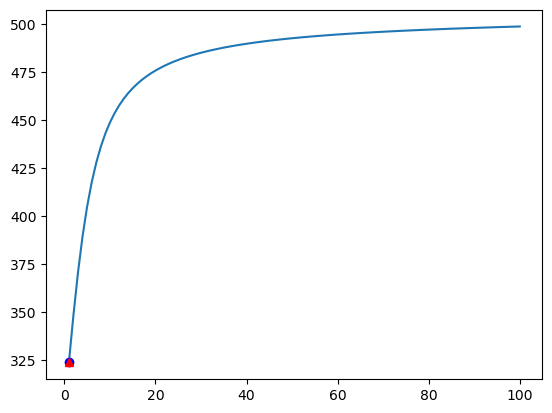

In [341]:
def objective(n, theta_0, v, a, q):
    return (A(theta_0 + q*v, n) - A(theta_0, n) + a) / q

qs = jnp.linspace(1.0001, 100, 100)
phis = np.array([
    objective(n, theta_0, v, a, q) for q in qs
]) 
plt.plot(qs, phis)
plt.plot(q_opt_qcp, objective(n, theta_0, v, a, q_opt_qcp), 'bo')
plt.plot(q_opt_qcp_cvxpy, objective(n, theta_0, v, a, q_opt_qcp_cvxpy), 'r^')

In [316]:
solver = QCPSolver(n, a)
solve_vmap_jit = jax.jit(jax.vmap(solver.solve, in_axes=(0, 0)))

def vectorize_run(key, m, d, a=-np.log(0.025), n=350):
    theta_0 = jax.random.normal(key, (m, d))
    _, key = jax.random.split(key)
    v = 0.001 * jax.random.normal(key, (m, d))
    return solve_vmap_jit(theta_0, v)

In [326]:
%%time
qs = vectorize_run(
    jax.random.PRNGKey(10),
    10000,
    3,
)

CPU times: user 699 ms, sys: 31.2 ms, total: 730 ms
Wall time: 726 ms


(array([4.690e+03, 3.491e+03, 1.112e+03, 3.140e+02, 1.500e+02, 9.200e+01,
        5.400e+01, 2.400e+01, 1.600e+01, 1.300e+01, 6.000e+00, 9.000e+00,
        5.000e+00, 3.000e+00, 3.000e+00, 2.000e+00, 3.000e+00, 2.000e+00,
        2.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 3.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([  39.17818069,  123.60180664,  208.0254364 ,  292.44906616,
         376.87268066,  461.29632568,  545.71990967,  630.14355469,
         714.56719971,  798.99084473,  883.41442871,  967.83807373,
        1052.26171875, 1136.68530273, 1221.10888672, 1305.53259277,
        1389.95617676, 1474.37988281, 1558.8034668 , 1643.22705078,
        1727.65075684, 1812.07434082, 1896.4979248 , 1980.92163086,
        2065.34521484, 2149.76879883, 2234.19238281, 2318.6159668 ,
        2403.03979492, 2487.46337891, 2571.88696289]),
 <BarContainer object of 30 artists>)

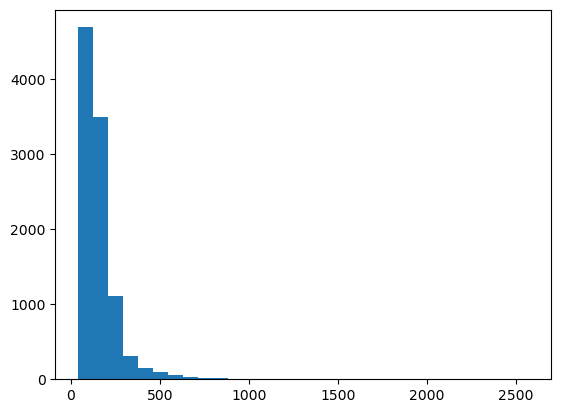

In [328]:
plt.hist(qs, bins=30)

## Optimizing q for Implicit Exponential Holder Bound

In [354]:
def objective_impl(n, theta_0, v, alpha, q):
    return (
        (A(theta_0 + q * v, n) - A(theta_0, n))
        - q * ((A(theta_0 + v, n) - A(theta_0, n)) + np.log(alpha))
    ) / (q-1)
    
def qcp_solve(n, theta_0, v, alpha):
    shift = (A(theta_0 + v, n) - A(theta_0, n)) + np.log(alpha)
    q = cp.Variable(pos=True)
    objective_fn = (
        (A_cp(theta_0 + (q+1) * v, n) - A(theta_0, n))
        - (q+1) * shift
    ) / q
    objective = cp.Minimize(objective_fn)
    problem = cp.Problem(objective)
    min = 0
    max = n * v - shift
    problem.solve(qcp=True, low=min+1e-6, high=max)
    return q.value + 1, problem.value

In [161]:
n = 350
theta_0 = -1
vs = np.linspace(0, 1, 100)
alpha = 0.025

/Users/jhyang/opt/miniconda3/envs/confirm/lib/python3.10/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/jhyang/opt/miniconda3/envs/confirm/lib/python3.10/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/jhyang/opt/miniconda3/envs/confirm/lib/python3.10/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


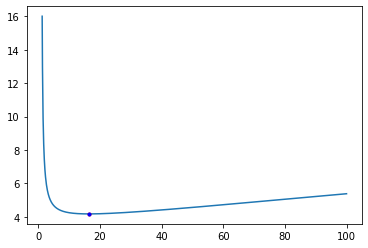

In [162]:
# cvxpy method
v = vs[2]
opt_q, opt_loss = qcp_solve(n, theta_0, v, alpha)

# brute force search method
qs = np.linspace(1.3, 100, 1000)
objs = np.array([objective(n, theta_0, v, alpha, q) for q in qs])
i_min = np.argmin(objs)

# plot
plt.plot(qs, objs)
plt.plot(qs[i_min], objs[i_min], 'r.')
plt.plot(opt_q, opt_loss, 'b.')